In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from copy import *
import os
import math


In [2]:
#Вход : X – множество, которое необходимо разбить на кластеры, k – число
#кластеров, n - максимальное число итераций.
def KMeans(X, k, max_iter): 
    # размер вектора
    n = X.shape[0]
    c = X.shape[1] # размерность х

    #рандомим изначальные центры
    idx = np.random.randint(n, size=k)
    centers = X[idx,:]
    
    centers_old = np.zeros(centers.shape) # to store old centers
    centers_new = deepcopy(centers) # Store new centers

    clusters = np.zeros(n)
    distances = np.zeros((n,k))

    error = 1000000

    while error != 0 and max_iter > 0:
        # Рассотяние от точки до каждого центра
        for i in range(k):
            distances[:,i] = np.linalg.norm(X - centers[i], axis=1)
        # К какому кластеру относится
        clusters = np.argmin(distances, axis = 1)
    
        centers_old = deepcopy(centers_new)
        # новые центры
        for i in range(k):
            centers_new[i] = np.mean(X[clusters == i], axis=0)
        error = np.linalg.norm(centers_new - centers_old)
        max_iter -= 1
    return centers_new, clusters            




In [3]:
def DaviesBouldin(X, centers, clusters):
    
    clust_num = len(centers)
    dists = [0 for i in range(0, clust_num)]
    n = [0 for i in range(0, clust_num)]

    for i in range(len(X)):
        c = clusters[i] #номер кластера
        dists[c] += np.linalg.norm(X[i] - centers[c])
        n[c] += 1 #кол-во элементов в кластере
    
    dists = [math.sqrt(dists[i]/n[i]) for i in range(clust_num)]
    res = []
    for i in range(clust_num):
        resi = []
        for j in range(clust_num):
            if i != j:
                resi.append((dists[i] + dists[j]) / np.linalg.norm(centers[i] - centers[j]))
        res.append(max(resi))
    return sum(res)/clust_num

In [4]:
def CalinskiHarabasz(X, centers, clusters):
    
    clust_num = len(centers)
    m = [np.zeros(shape = (1, X.shape[1])) for i in range(0, clust_num)]
    n = [0 for i in range(0, clust_num)]
    M = np.zeros(shape = (1, X.shape[1]))
    for i in range(len(X)):
        c = clusters[i] #номер кластера
        m[c] += X[i]
        n[c] += 1 #кол-во элементов в кластере
        M += X[i]
    
    m = [m[i]/n[i] for i in range(clust_num)]
    M = M /X.shape[0]
    
    SB = sum([n[i]*((m[i] - M).T.dot((m[i]-M))) for i in range(clust_num)])#так как в начале х у нас вектор-строки
    SW = np.zeros(shape=(X.shape[1],X.shape[1]))
    
    for i in range(clust_num):
        xx = [X[j] for j in range(X.shape[0]) if clusters[j] == i]
        for xj in xx:
            SW += (xj-m[i]).T.dot(xj-m[i])
            
                 
    
    CH = (X.shape[0] - clust_num)/(clust_num - 1) * np.trace(SB)/np.trace(SW)
    
    return CH

In [5]:
def BestKMeans(X):
    max_clust = 15
    DB = [] 
    CH = []
    n = 135

    for i in range(2, max_clust):
        cent, clust = KMeans(X, i, n)
        DB.append(DaviesBouldin(X, cent, clust))
        CH.append(CalinskiHarabasz(X, cent, clust))
    delta = [ ((CH[i+1]-CH[i])-(CH[i] - CH[i-1]))  for i in range(1, max_clust - 3)] 
    
    k_best = min(DB.index(min(DB))+2, delta.index(min(delta))+3) # если не совпадают, возьмем минимум

    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(8, 4)
        )
    ax1.set_xlabel('number of clusters')
    ax1.set_ylabel('Index')
    
    ax2.set_xlabel('number of clusters')
    ax2.set_ylabel('Index')
    
    ax1.set_title('DB')
    ax2.set_title('CH')

    ax1.plot([i for i in range(2, max_clust)], DB, color='blue',  label='DB')
    ax2.plot([i for i in range(2, max_clust)], CH, color='red', label='CH')
    ax2.plot([i for i in range(3, max_clust-1)], delta, color='green', label='delta')
    ax2.legend(loc='best')
    
    
    return KMeans(X, k_best, n)

In [6]:
def convertImage(input_image_file, output_image_file = None):
    image = np.array(Image.open(input_image_file))
    X = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))
   
    cent, clust = BestKMeans(X)
    #print(cent, clust)
    new_X = np.vstack([cent[i] for i in clust])
    new_image = new_X.reshape(image.shape)
    Image.fromarray(new_image).save(output_image_file)
    display(Image.fromarray(image), Image.fromarray(new_image)) #

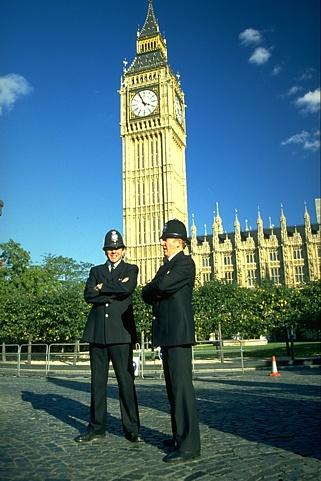

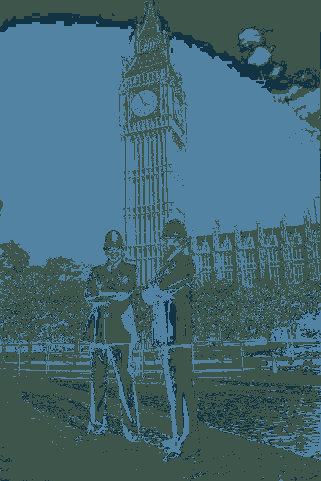

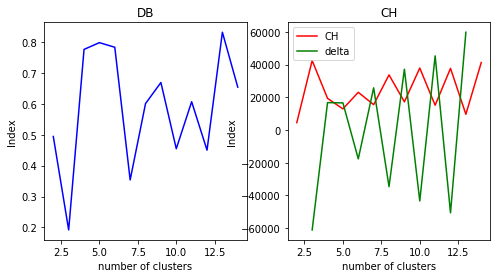

In [7]:
convertImage(os.path.abspath("policemen.jpg"), "out.jpg")

In [8]:
def RandIndex(TP, FN, FP, TN):
    return (TP+TN)/(TP+TN+FN+FP)

In [9]:
def FowlkesMallowsIndex( TP, FN, FP, TN):    
    return TP/math.sqrt((TP + FN)*(TP + FP))

In [10]:
def convertTxt(file_name):
    #читаем данные
    data = np.genfromtxt(file_name, delimiter=' ')
    Y_Real = data[:, 0]
    y_set = list(set(Y_Real))
    y_set.sort()
    X = data[:, 1:]
    max_clust = 15
    Random = [] 
    FM = []
    for k in range(2, max_clust):    
        _, clust = KMeans(X, k, max_iter = 100)
        N = np.zeros((len(y_set), k))
        for i in range(0, len(X)):
            N[y_set.index(Y_Real[i])][clust[i]] += 1  
        n = np.sum(N)
        n_2 =  sum(N[i][j]**2 for i in range(0, len(y_set)) for j in range(0, k))    
        n_i = np.sum(N, axis = 1)
        m_j = np.sum(N, axis = 0)
        TP = (n_2 - n)/2
        FN = (sum(mj**2 for mj in m_j) - n_2)/2
        FP = (sum(ni**2 for ni in n_i) - n_2)/2
        TN = (n*(n-1))/2 - TP - FN - FP
        Random.append(RandIndex(TP, FN, FP, TN))
        FM.append(FowlkesMallowsIndex(TP, FN, FP, TN))
    plt.xlabel('number of clusters')
    plt.ylabel('Index')
    
    plt.plot([i for i in range(2, max_clust)], Random, color='blue',  label='Random')
    plt.plot([i for i in range(2, max_clust)], FM, color='red', label='FM')
    plt.legend(loc='best')

    return

/home/irik/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/irik/.local/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


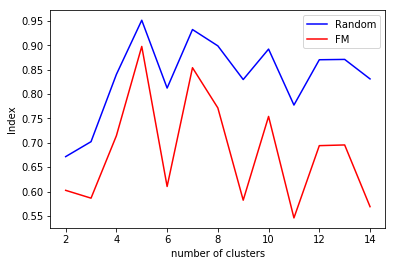

In [11]:
convertTxt(os.path.abspath('t.txt'))